## TRCWA

This notebook compares NIDN's RCWA implementation with GRCWA.

In [1]:
### Imports
%load_ext autoreload
%autoreload 2

# Append main folder
import sys
sys.path.append("../..")

import nidn
import grcwa
import torch
import numpy as npf
import autograd.numpy as np
from autograd import grad

12:00:23|NIDN-INFO| Initialized NIDN for cpu
12:00:23|NIDN-INFO| Using double precision


In [2]:
# Start with the default config
cfg = nidn.load_default_cfg()

## Three Layer Uniform

### TRCWA

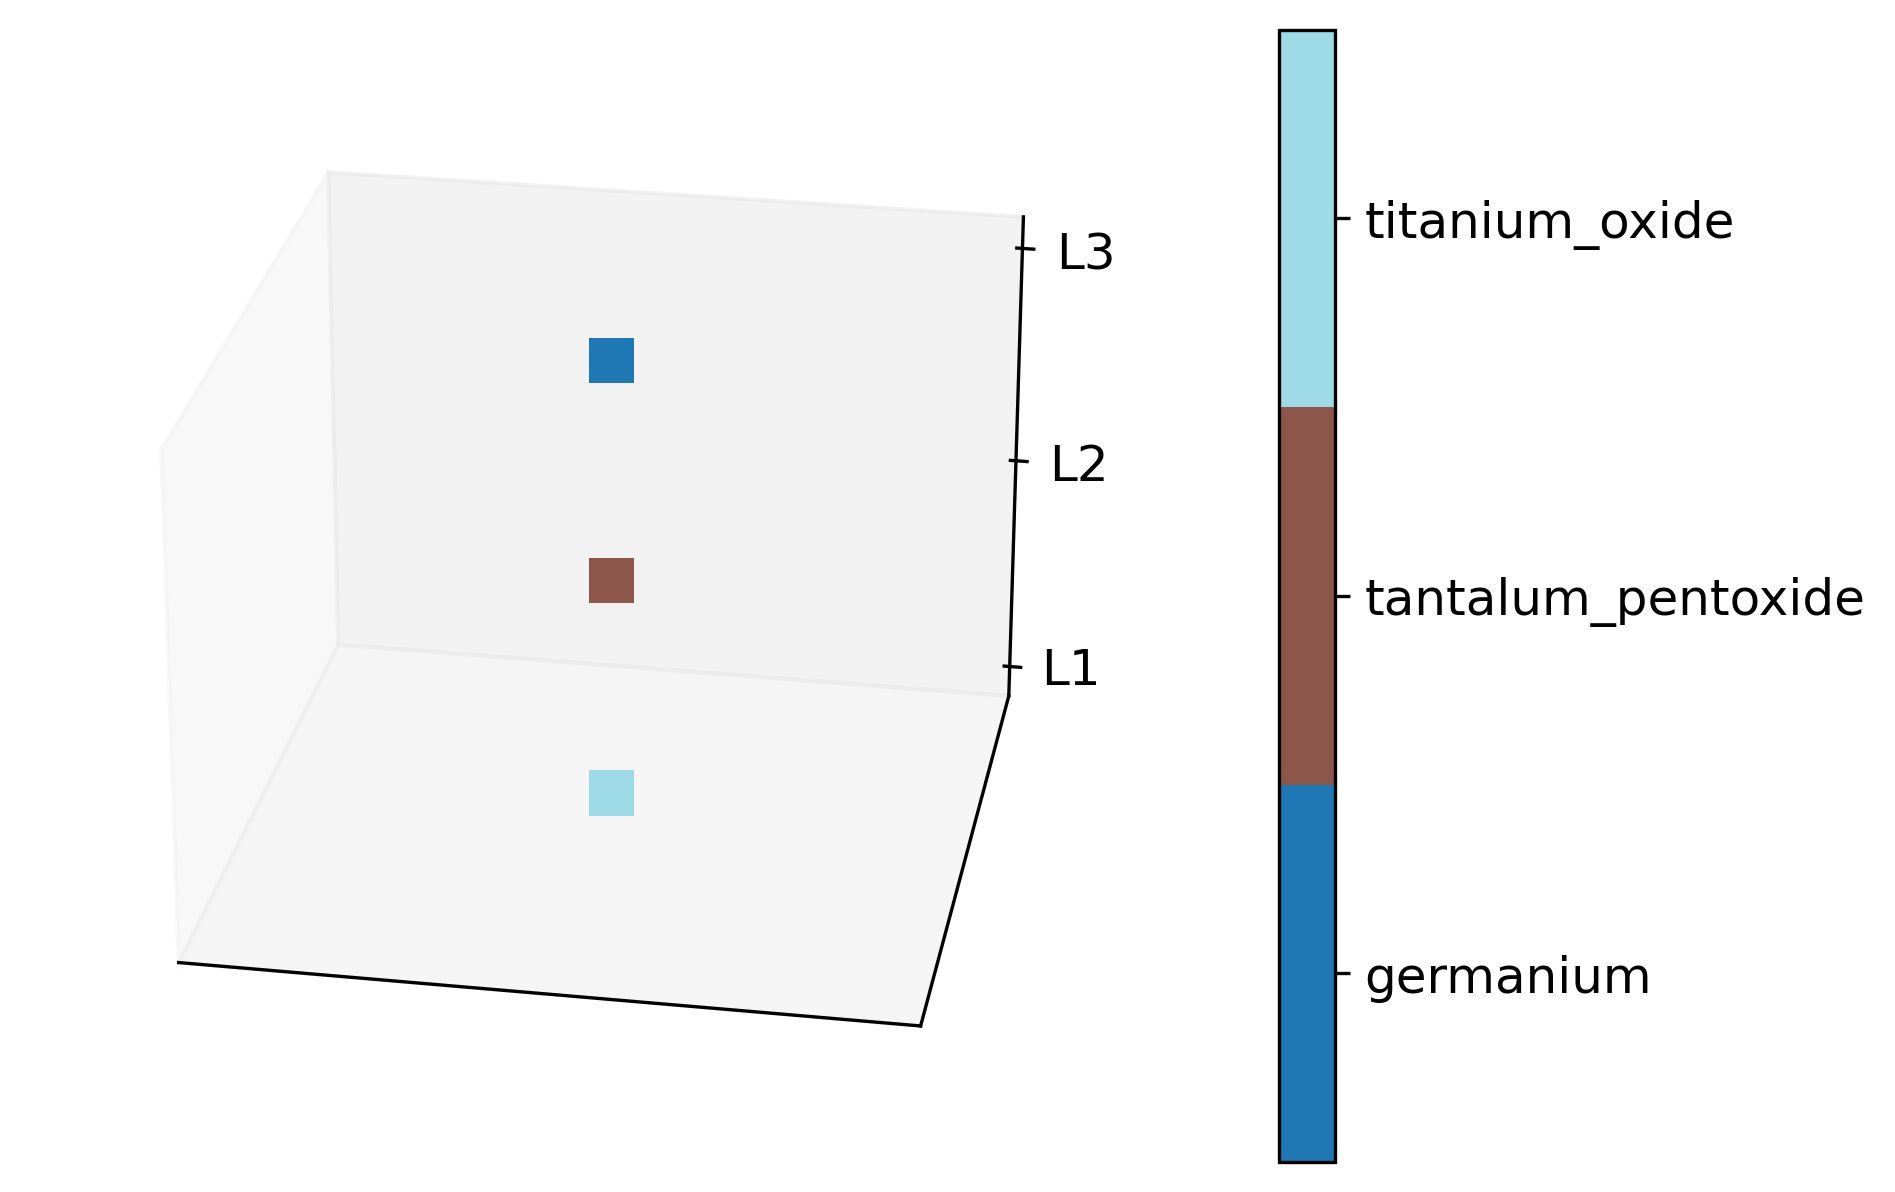

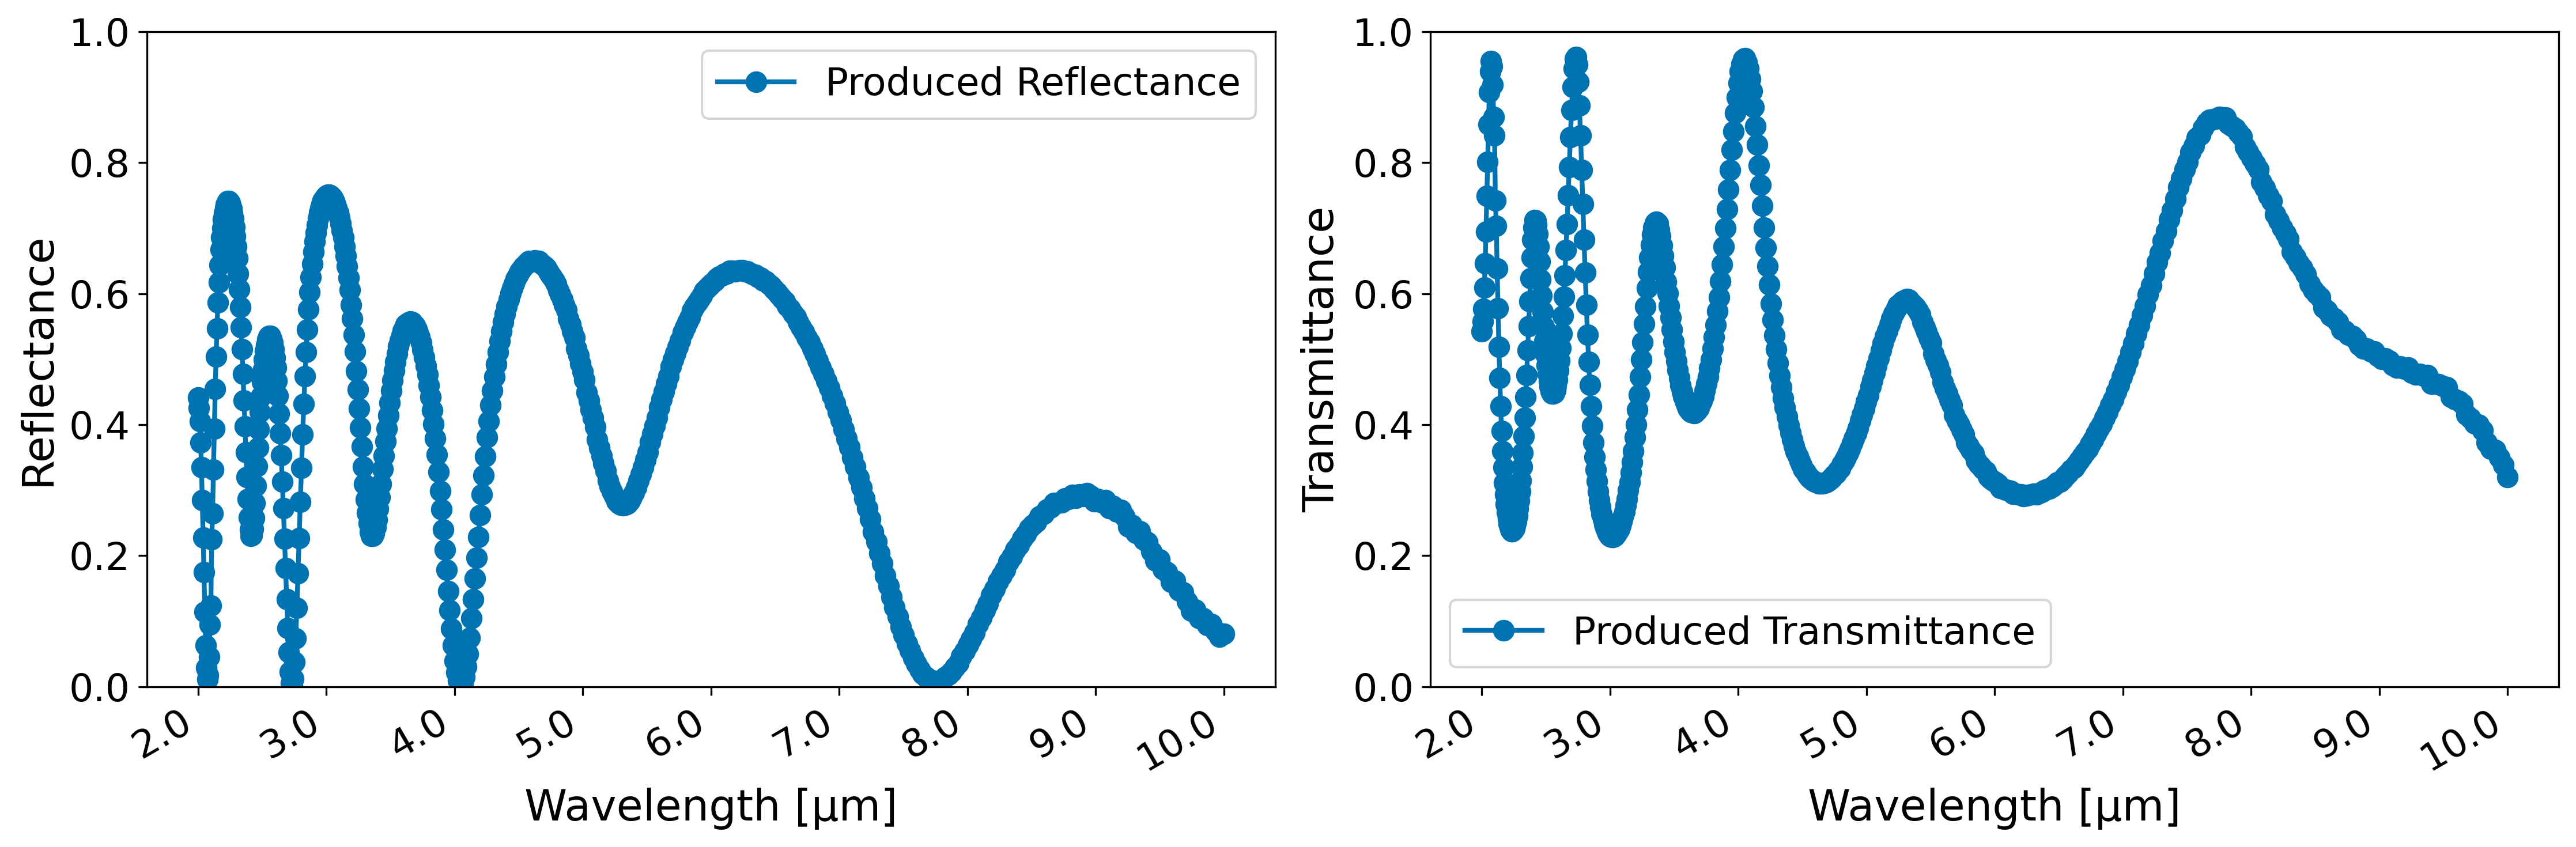

In [18]:
# Set grid specifics
# Change to 32 to generate grid plot with more than 1 element displayed
cfg.Nx = 1
cfg.Ny = 1
cfg.N_layers = 3
cfg.N_freq = 500
cfg.TRCWA_L_grid = [[0.1,0.0],[0.0,0.1]]
cfg.TRCWA_NG = 11
cfg.PER_LAYER_THICKNESS = [1.0]
cfg.freq_distribution = "log"

# Specify your desired range of wavelengths
cfg.physical_wavelength_range[0] = 2e-6
cfg.physical_wavelength_range[1] = 1e-5

# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)

# Print run config
# nidn.print_cfg(cfg)

# Init eps_grid
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)

layer_builder = nidn.LayerBuilder(cfg)

# Uniform Titanium oxide
eps_grid[:,:,0,:] = layer_builder.build_uniform_layer("titanium_oxide")
eps_grid[:,:,1,:] = layer_builder.build_uniform_layer("tantalum_pentoxide")
eps_grid[:,:,2,:] = layer_builder.build_uniform_layer("germanium")
# eps_grid[:,:,0,:] = layer_builder.build_circle_layer("tantalum_pentoxide","titanium_oxide")

nidn.plot_material_grid(cfg,eps=eps_grid,to_skip=["zinc_oxide","indium_arsenide","silicon_nitride","gallium_arsenide",
                                                  "aluminium_oxide","aluminium_nitride","aluminium_arsenide"])

# Compute spectrum for this configuration
R_nidn,T_nidn = nidn.compute_spectrum(eps_grid,cfg)

nidn.plot_spectrum(cfg,R_nidn,T_nidn)

### GRCWA

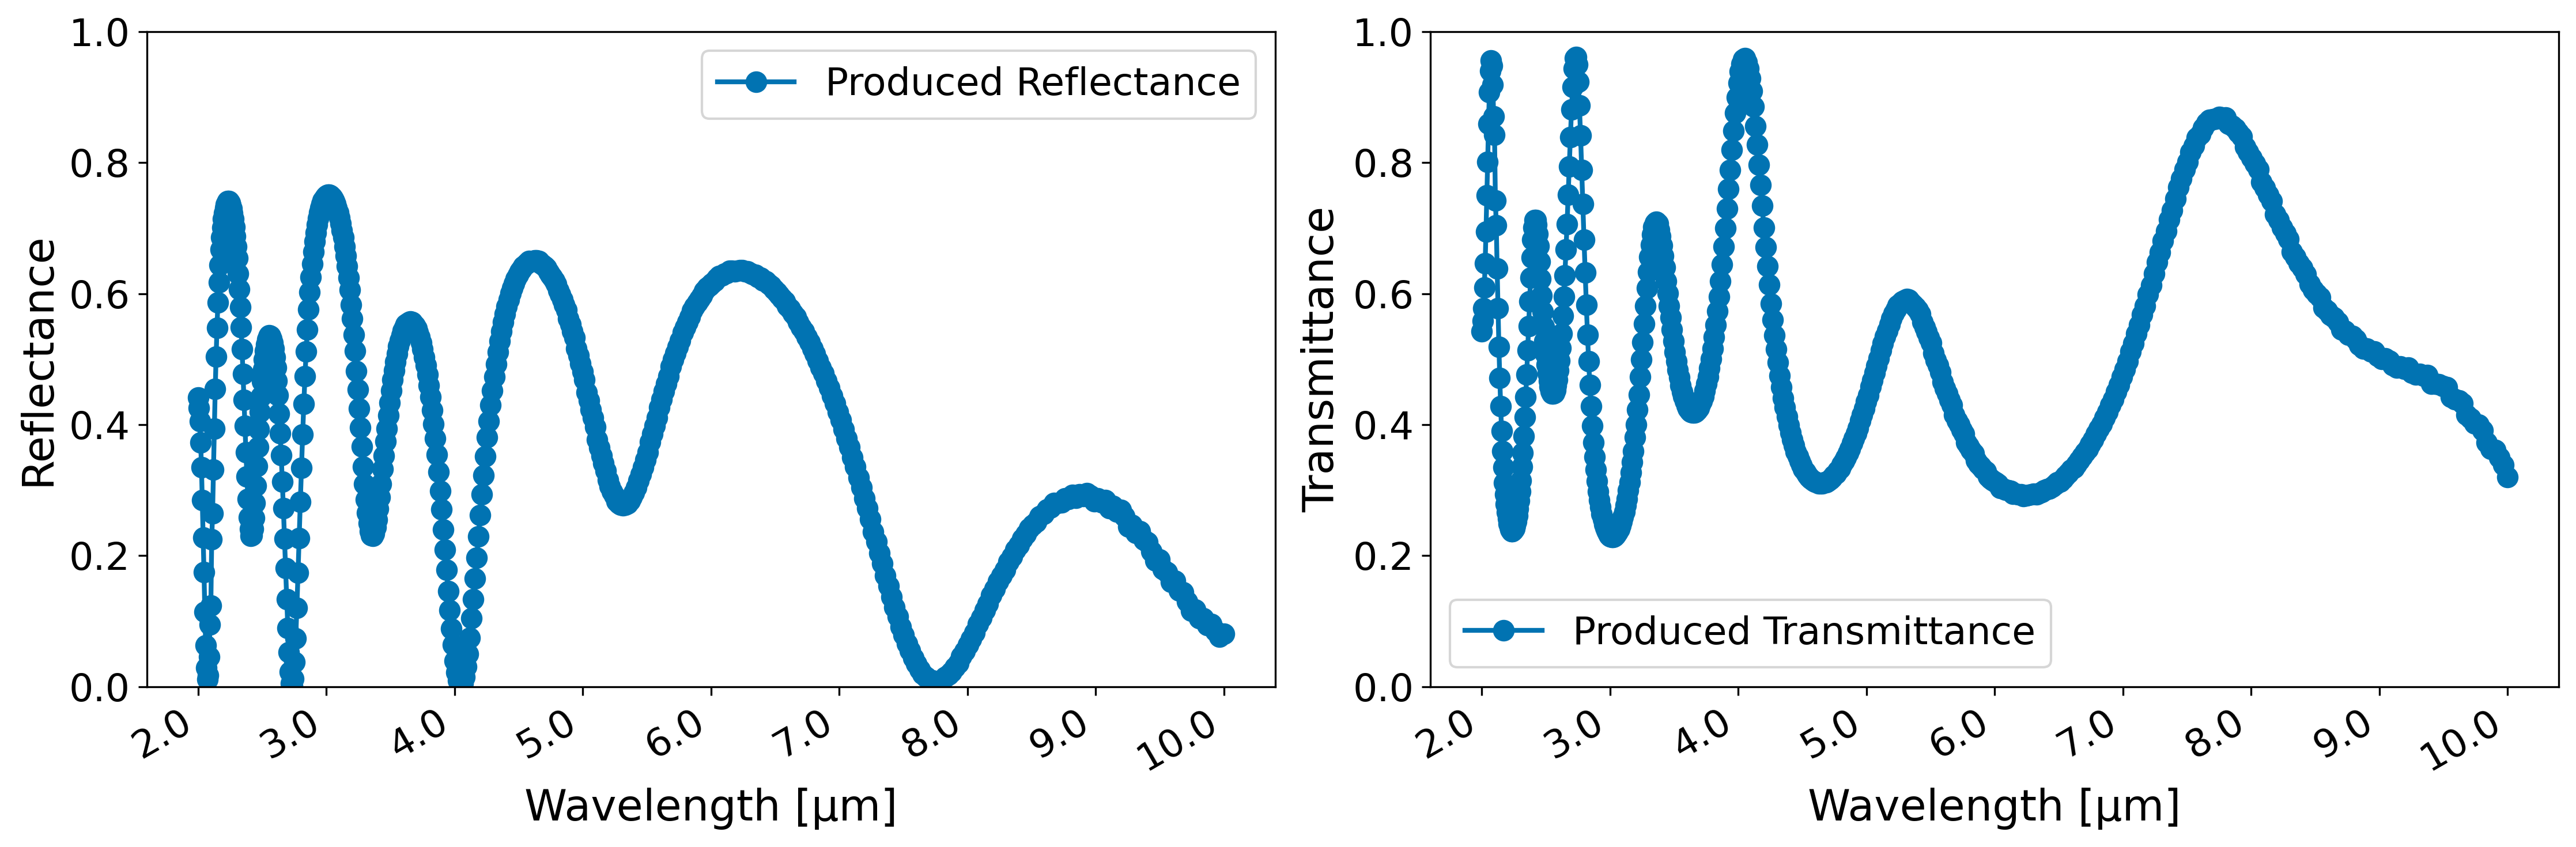

In [19]:
# Truncation order (actual number might be smaller)
nG = 11
# lattice constants
L1 = [0.1,0]
L2 = [0,0.1]
# frequency and angles

theta = 0.
phi = 0.

# now consider 3 layers: vacuum + patterned + vacuum
ep0 = 1. # dielectric for layer 1 (uniform)
epN = 1.  # dielectric for layer N (uniform)

thick0 = 1. # thickness for vacuum layer 1
thickN = 1.

# planewave excitation
planewave={'p_amp':0,'s_amp':1,'p_phase':0,'s_phase':0}


def fun_reflection(x,Qabs,freq):
    freqcmp = freq*(1+1j/2/Qabs)
    ######### setting up RCWA
    obj = grcwa.obj(nG,L1,L2,freqcmp,theta,phi,verbose=0)
    # input layer information
    obj.Add_LayerUniform(thick0,ep0)
    obj.Add_LayerUniform(thick0,x[:,:,0][0])
    obj.Add_LayerUniform(thick0,x[:,:,1][0])
    obj.Add_LayerUniform(thick0,x[:,:,2][0])
    obj.Add_LayerUniform(thickN,epN)
    obj.Init_Setup()

    obj.MakeExcitationPlanewave(planewave['p_amp'],planewave['p_phase'],planewave['s_amp'],planewave['s_phase'],order = 0)    
#     x = np.concatenate((x[:,:,0].flatten(),x[:,:,1].flatten(),x[:,:,2].flatten()))
#     obj.GridLayer_geteps(x)
    R,T= obj.RT_Solve(normalize=1)
    return R,T

Rs,Ts = [],[]


for idx,freq in enumerate(cfg.target_frequencies):
    R,T = fun_reflection(eps_grid[:,:,:,idx].numpy(),1e16,freq)
    Rs.append(R)
    Ts.append(T)
    
nidn.plot_spectrum(cfg,Rs,Ts)

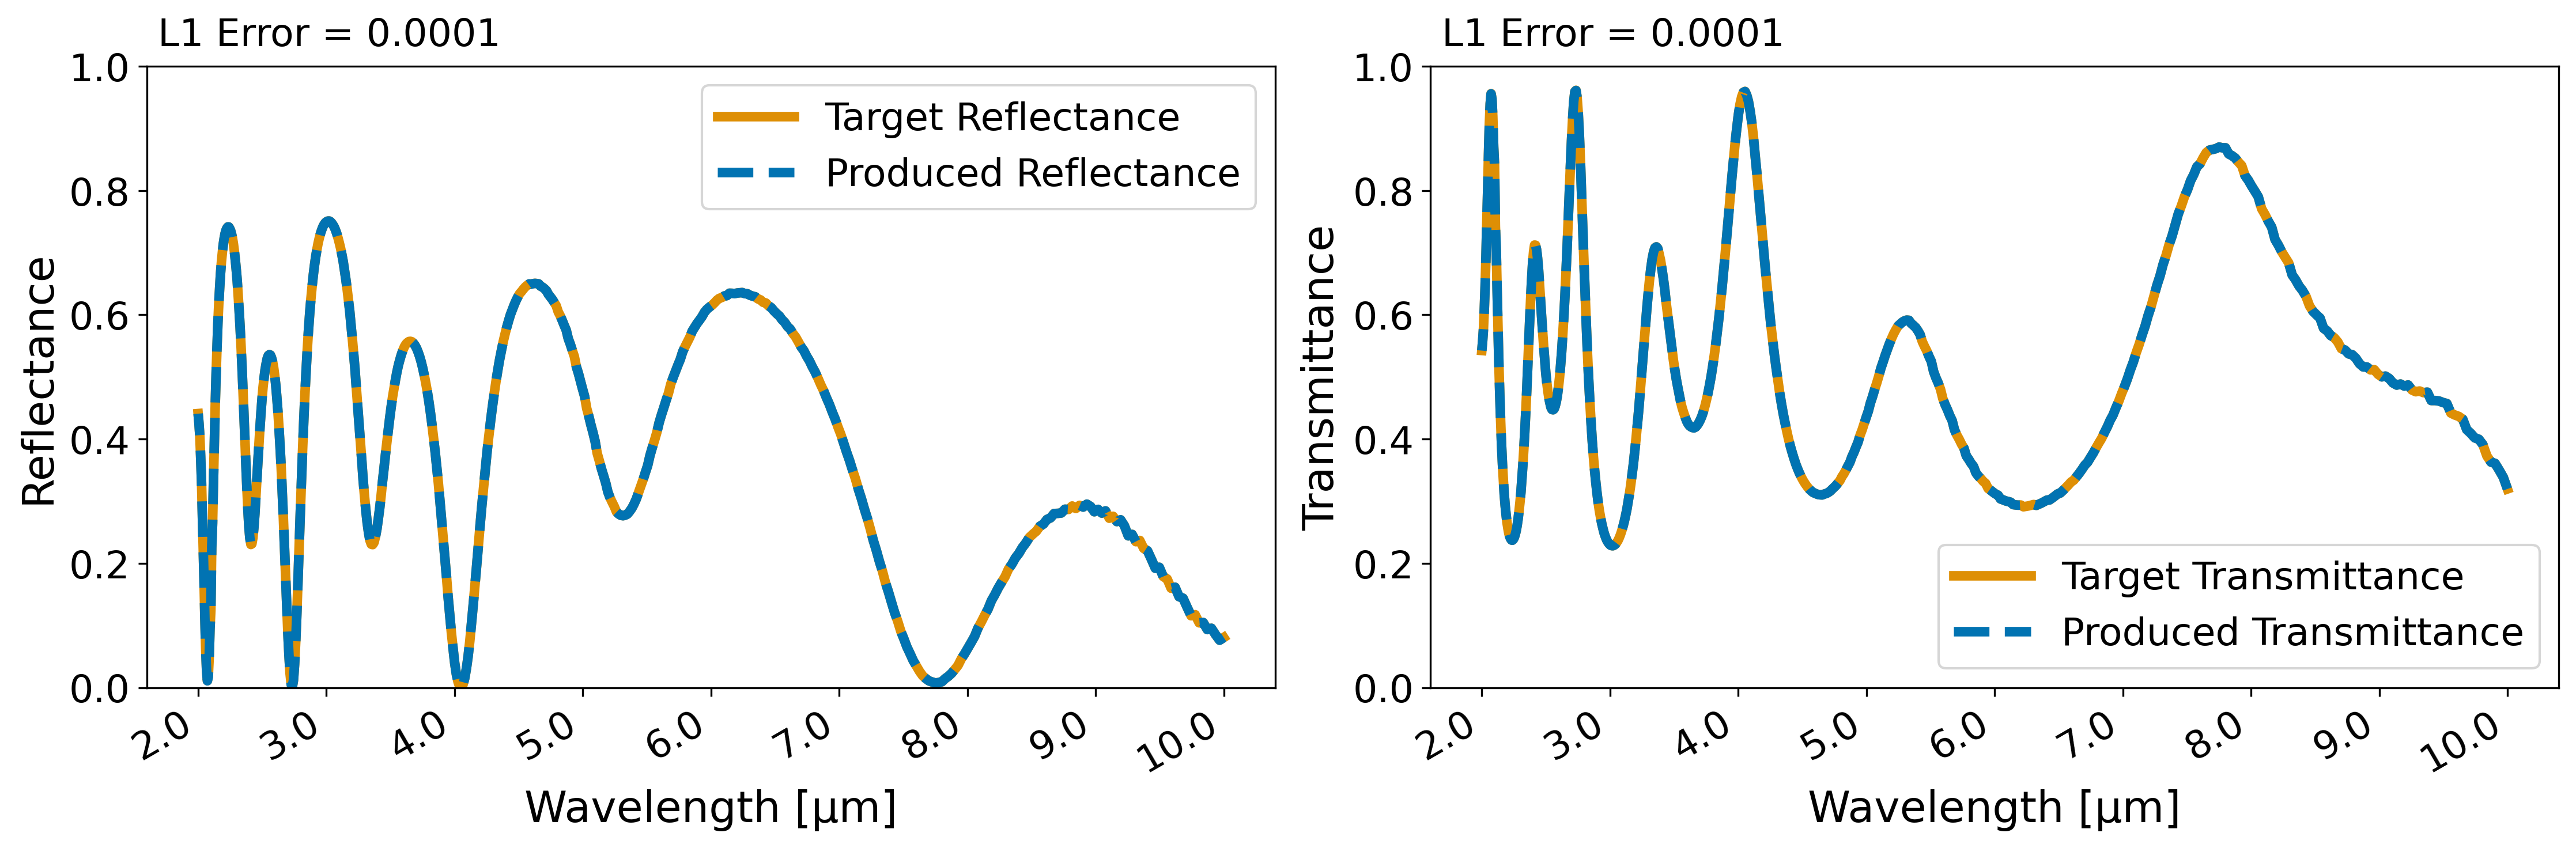

In [20]:
cfg.target_reflectance_spectrum = Rs
cfg.target_transmittance_spectrum = Ts
nidn.plot_spectra(cfg,prod_R_spectrum=R_nidn,prod_T_spectrum=T_nidn,markers=False,
                  save_path="../../results/",filename="trcwa_vs_grcwa_uniform")

In [21]:
R_errs = np.abs(np.array(R_nidn) - np.array(Rs))
T_errs = np.abs(np.array(T_nidn) - np.array(Ts))
print("R_errs",R_errs.mean())
print("T_errs",T_errs.mean())
errs = np.concatenate([R_errs,T_errs])
print("Overall",errs.mean())

R_errs 7.539647233283606e-05
T_errs 8.279001172605733e-05
Overall 7.909324202944669e-05


## Two Layer Patterned

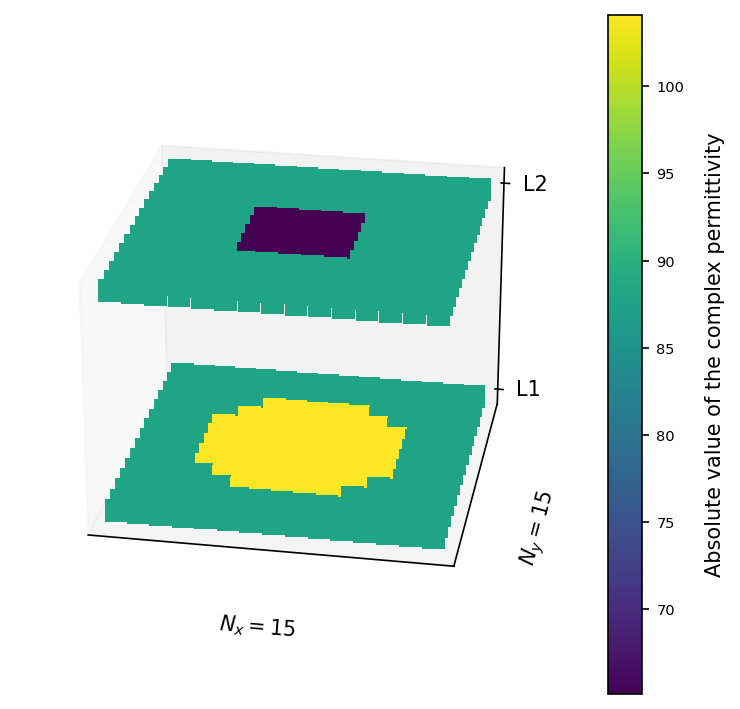

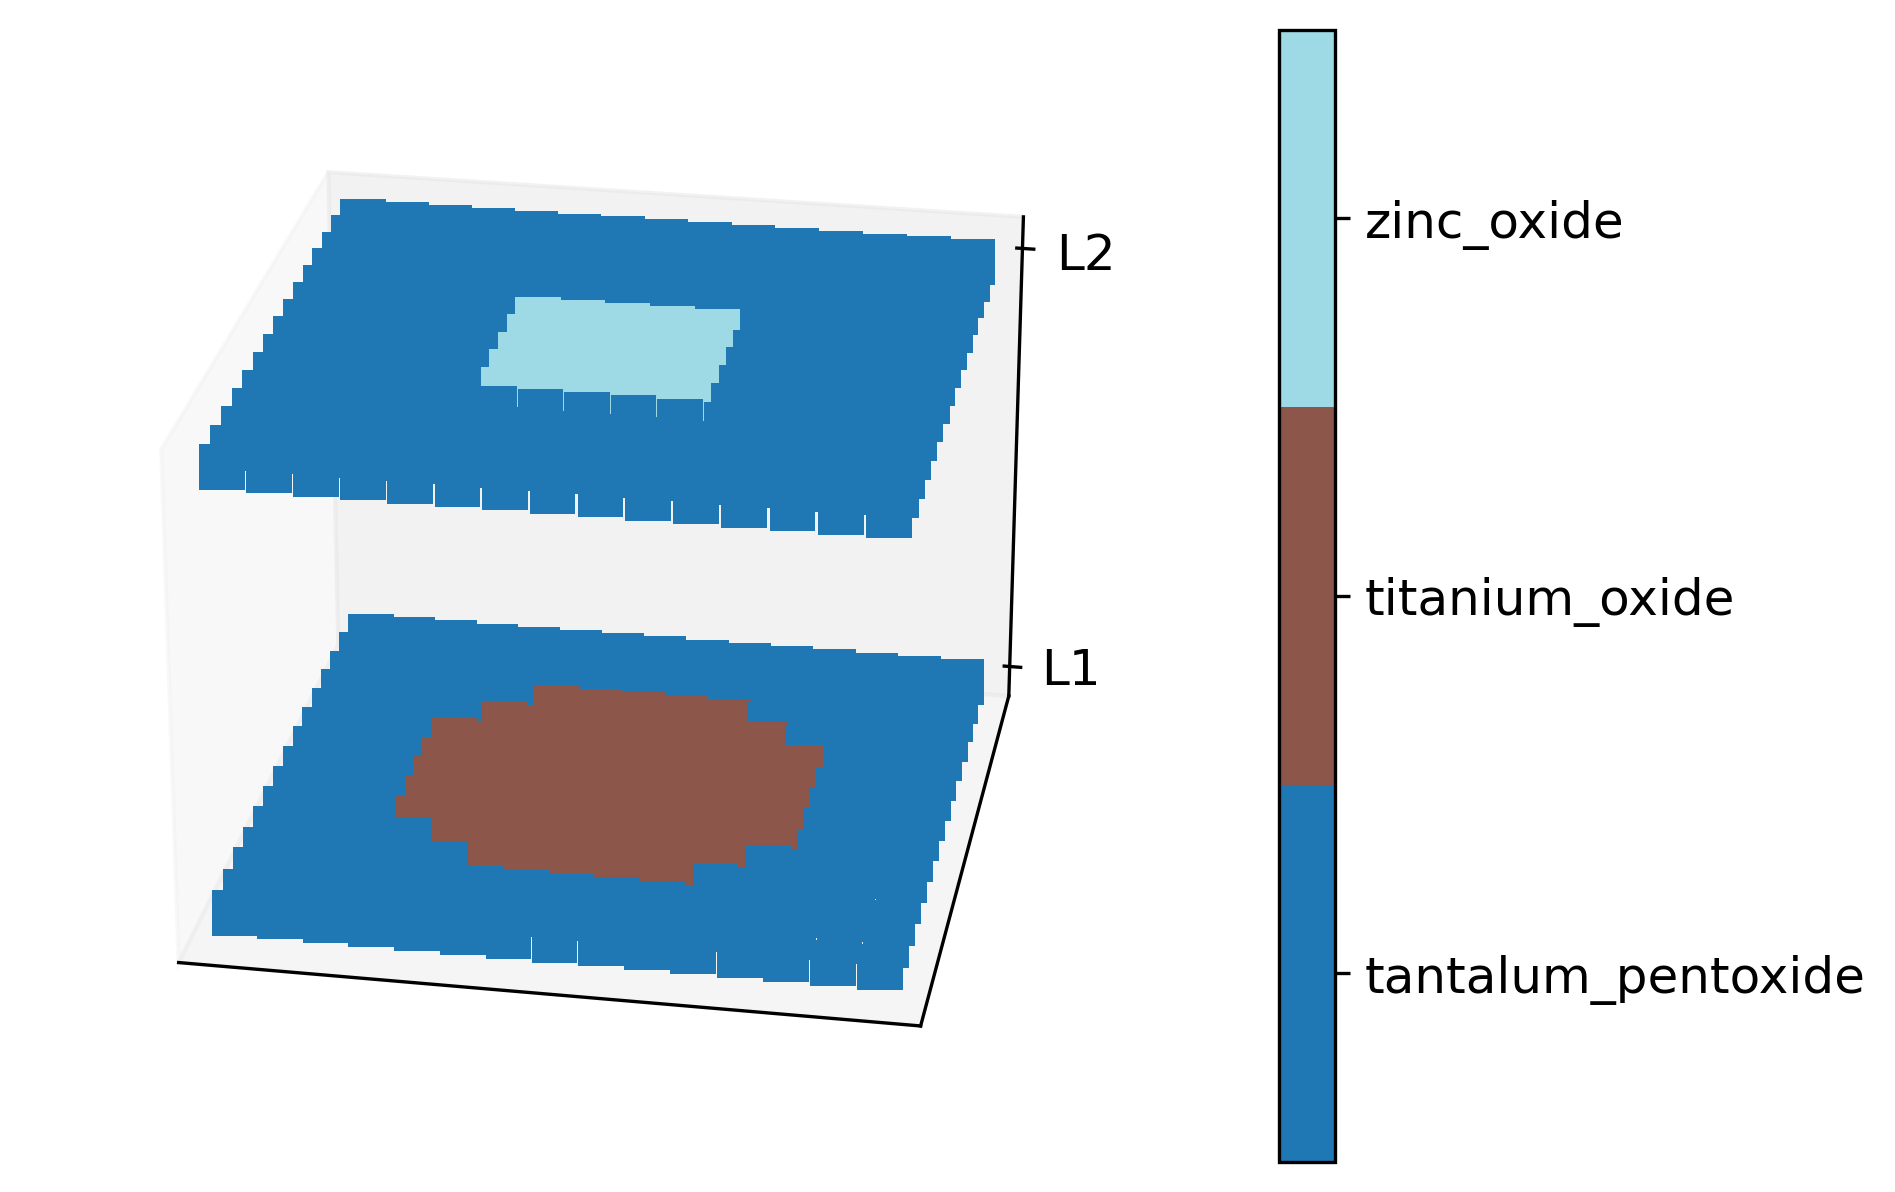

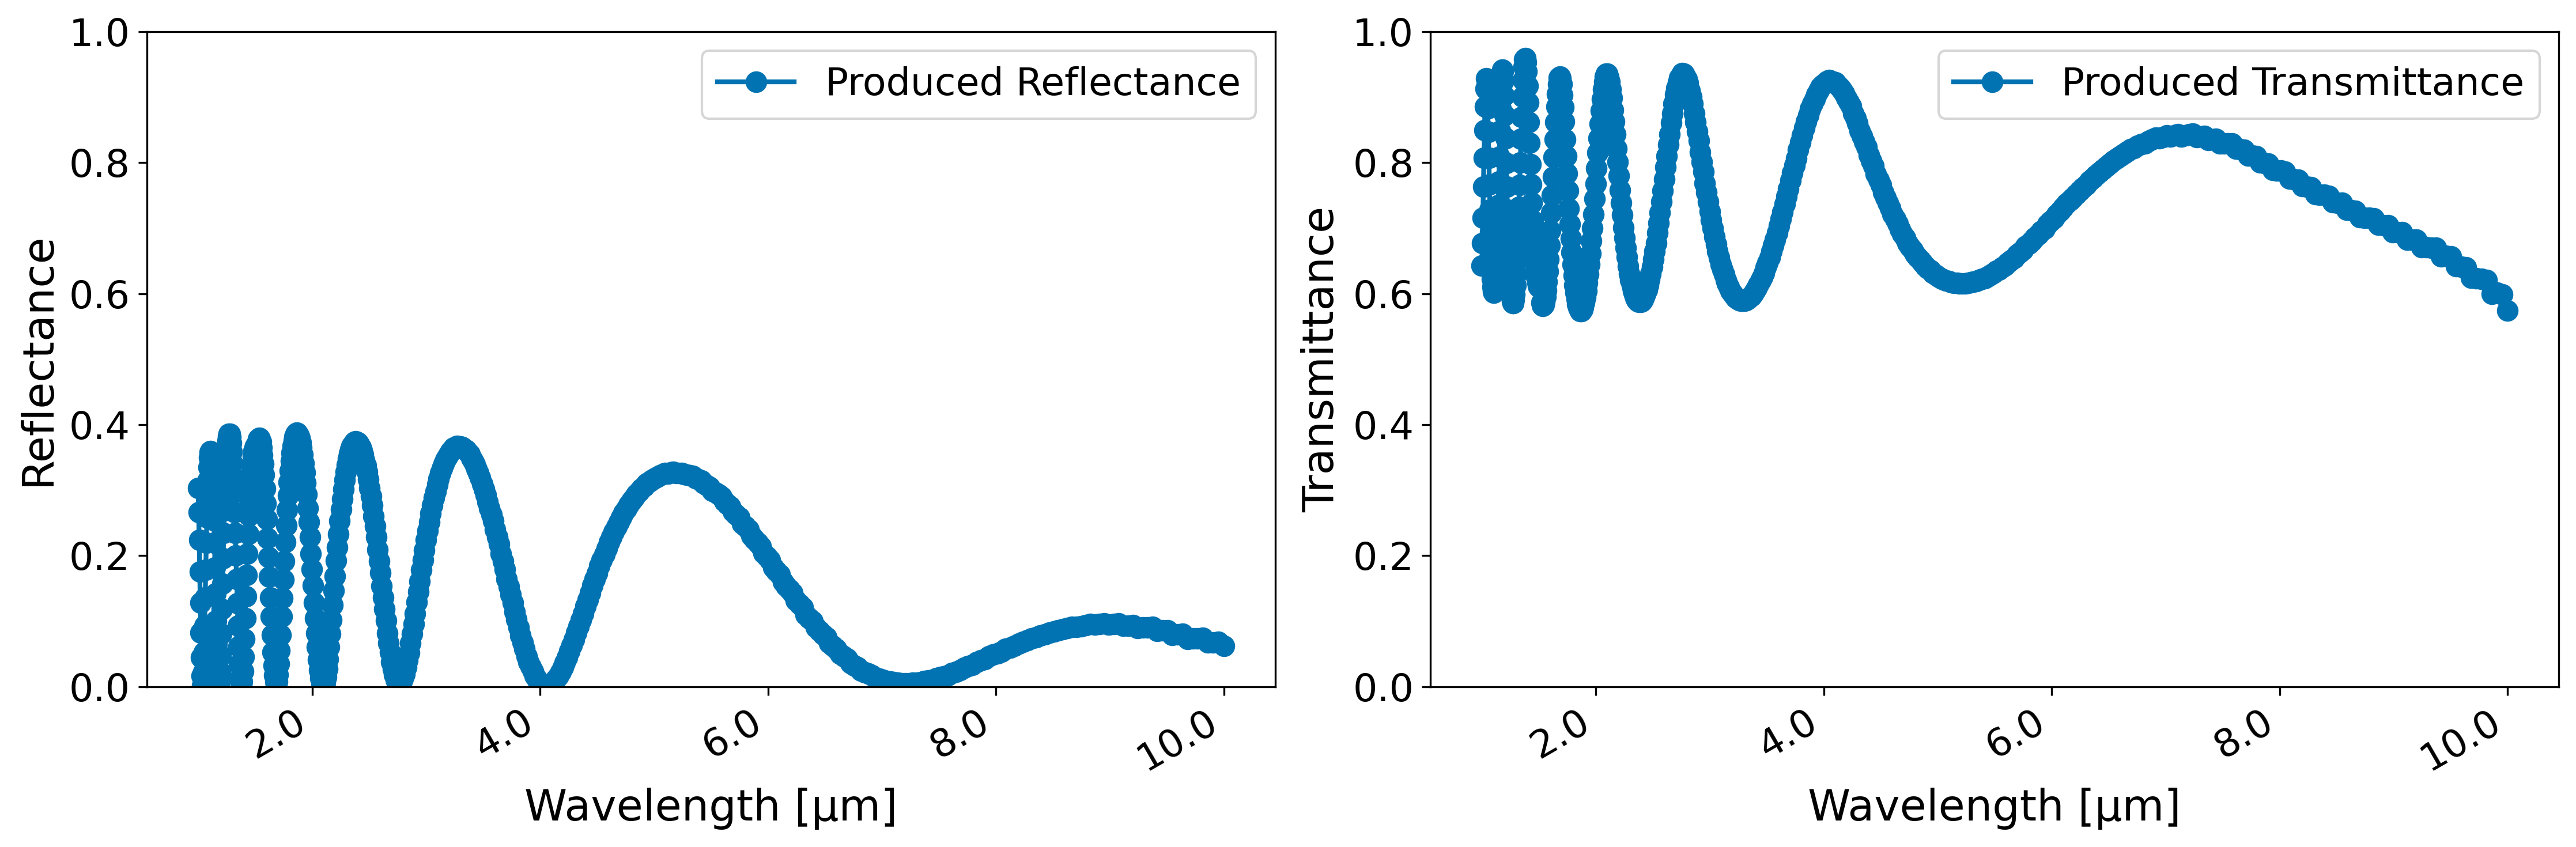

In [14]:
# Titanium Oxide Uniform
# Set grid specifics
cfg.Nx = 15
cfg.Ny = 15
cfg.N_layers = 2
cfg.N_freq = 500
cfg.TRCWA_L_grid = [[0.1,0.0],[0.0,0.1]]
cfg.TRCWA_NG = 11
cfg.PER_LAYER_THICKNESS = [1.0]
cfg.freq_distribution = "log"

# Specify your desired range of wavelengths
cfg.physical_wavelength_range[0] = 1e-6
cfg.physical_wavelength_range[1] = 1e-5

# Determine target frequencies (in TRCWA units)
cfg.target_frequencies = nidn.compute_target_frequencies(
    cfg.physical_wavelength_range[0],
    cfg.physical_wavelength_range[1],
    cfg.N_freq,
    cfg.freq_distribution
)


# Init eps_grid
eps_grid = torch.zeros(cfg.Nx,cfg.Ny,cfg.N_layers,cfg.N_freq,dtype=torch.cfloat)

layer_builder = nidn.LayerBuilder(cfg)

# Uniform Titanium oxide
eps_grid[:,:,0,:] = layer_builder.build_circle_layer("tantalum_pentoxide","titanium_oxide")
eps_grid[:,:,1,:] = layer_builder.build_squared_layer("tantalum_pentoxide","zinc_oxide")

# Plot the abs values of the produced grid
nidn.plot_epsilon_grid(eps_grid,cfg)
nidn.plot_material_grid(cfg,eps=eps_grid,to_skip=["germanium","indium_arsenide","silicon_nitride","gallium_arsenide",
                                                  "aluminium_oxide","aluminium_nitride","aluminium_arsenide"])

# Compute spectrum for this configuration
R_nidn,T_nidn = nidn.compute_spectrum(eps_grid,cfg)

nidn.plot_spectrum(cfg,R_nidn,T_nidn)

### GRCWA

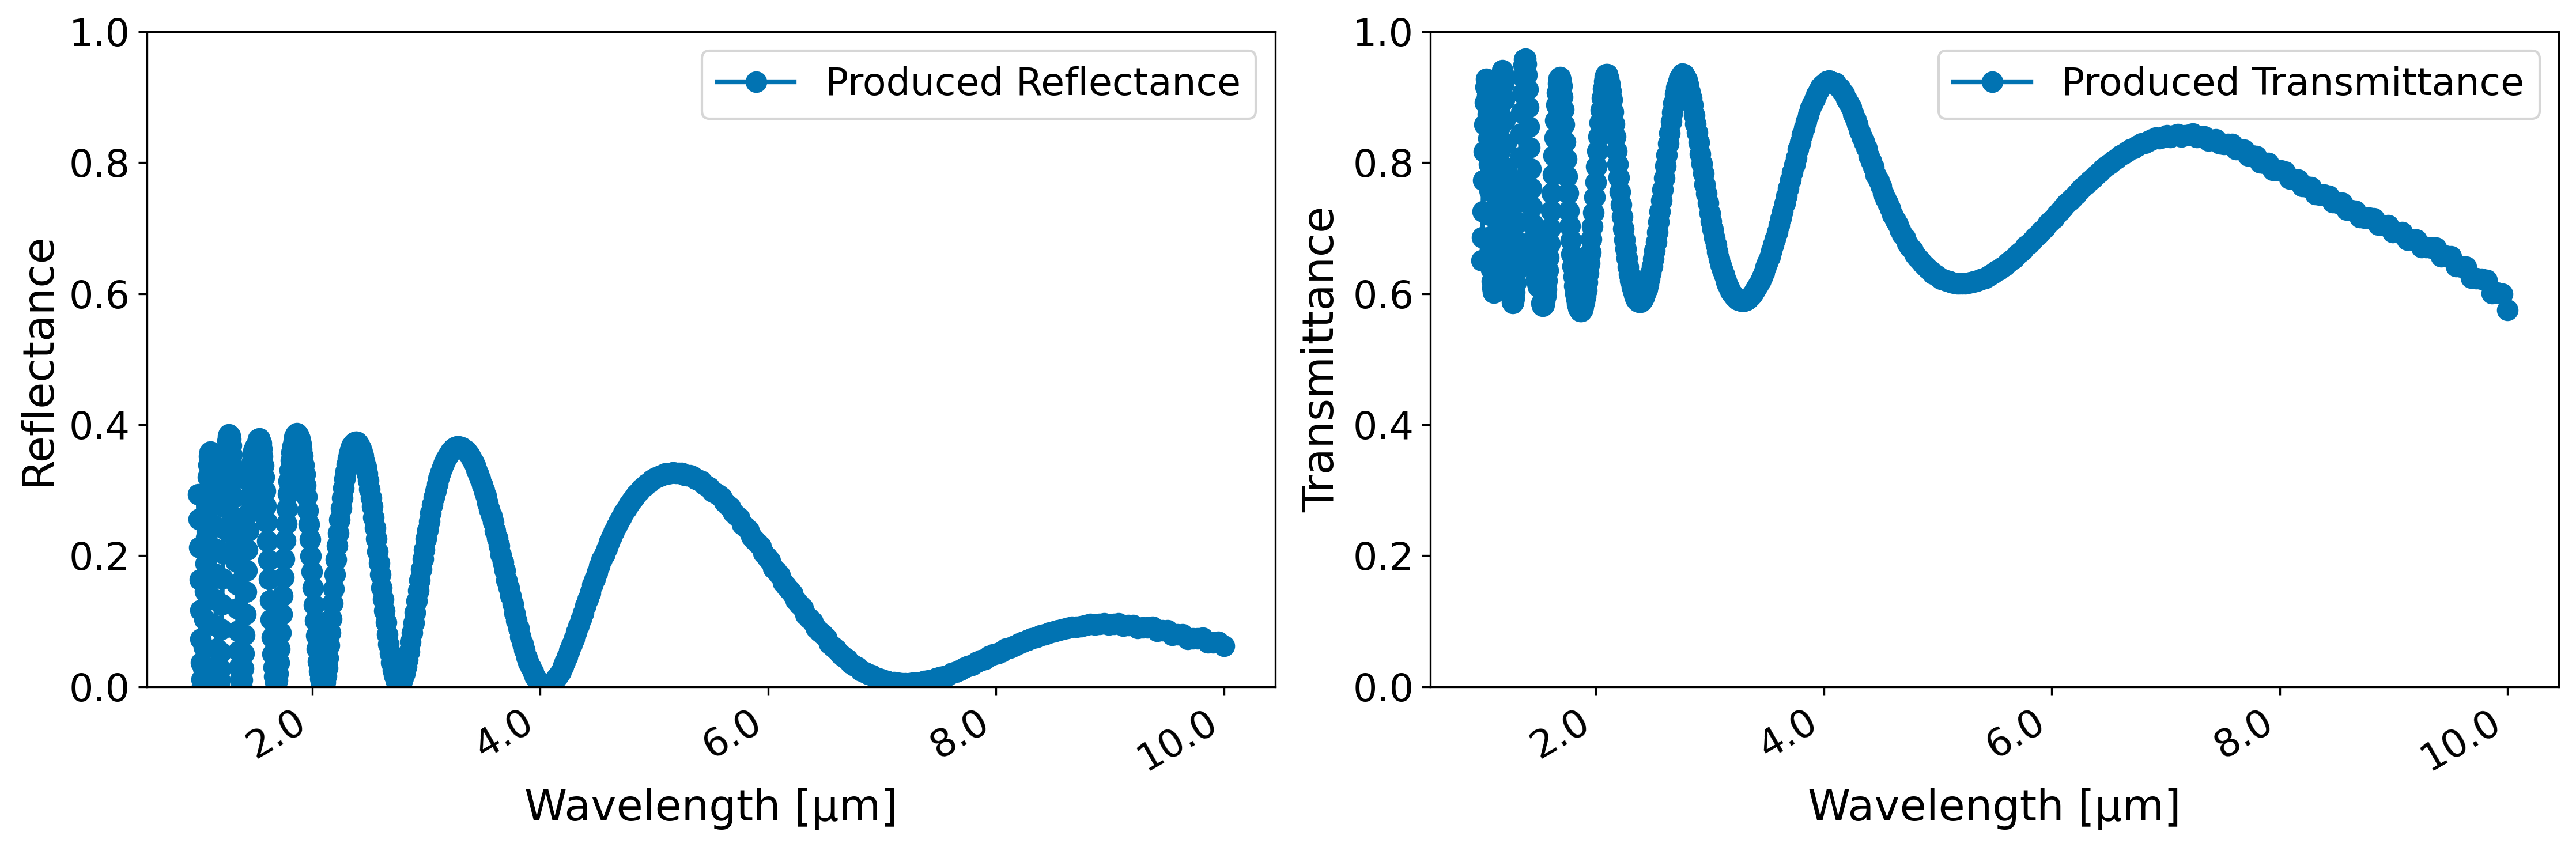

In [15]:
def fun_reflection(x,Qabs,freq):
    freqcmp = freq*(1+1j/2/Qabs)
    ######### setting up RCWA
    obj = grcwa.obj(nG,L1,L2,freqcmp,theta,phi,verbose=0)
    # input layer information
    obj.Add_LayerUniform(thick0,ep0)
    obj.Add_LayerGrid(thick0,cfg.Nx,cfg.Ny)
    obj.Add_LayerGrid(thick0,cfg.Nx,cfg.Ny)
    obj.Add_LayerUniform(thickN,epN)
    obj.Init_Setup()

    obj.MakeExcitationPlanewave(planewave['p_amp'],planewave['p_phase'],planewave['s_amp'],planewave['s_phase'],order = 0)    
    x = np.concatenate((x[:,:,0].flatten(),x[:,:,1].flatten()))
    obj.GridLayer_geteps(x)
    R,T= obj.RT_Solve(normalize=1)
    return R,T

Rs,Ts = [],[]


for idx,freq in enumerate(cfg.target_frequencies):
    R,T = fun_reflection(eps_grid[:,:,:,idx].numpy(),1e16,freq)
    Rs.append(R)
    Ts.append(T)
    
nidn.plot_spectrum(cfg,Rs,Ts)

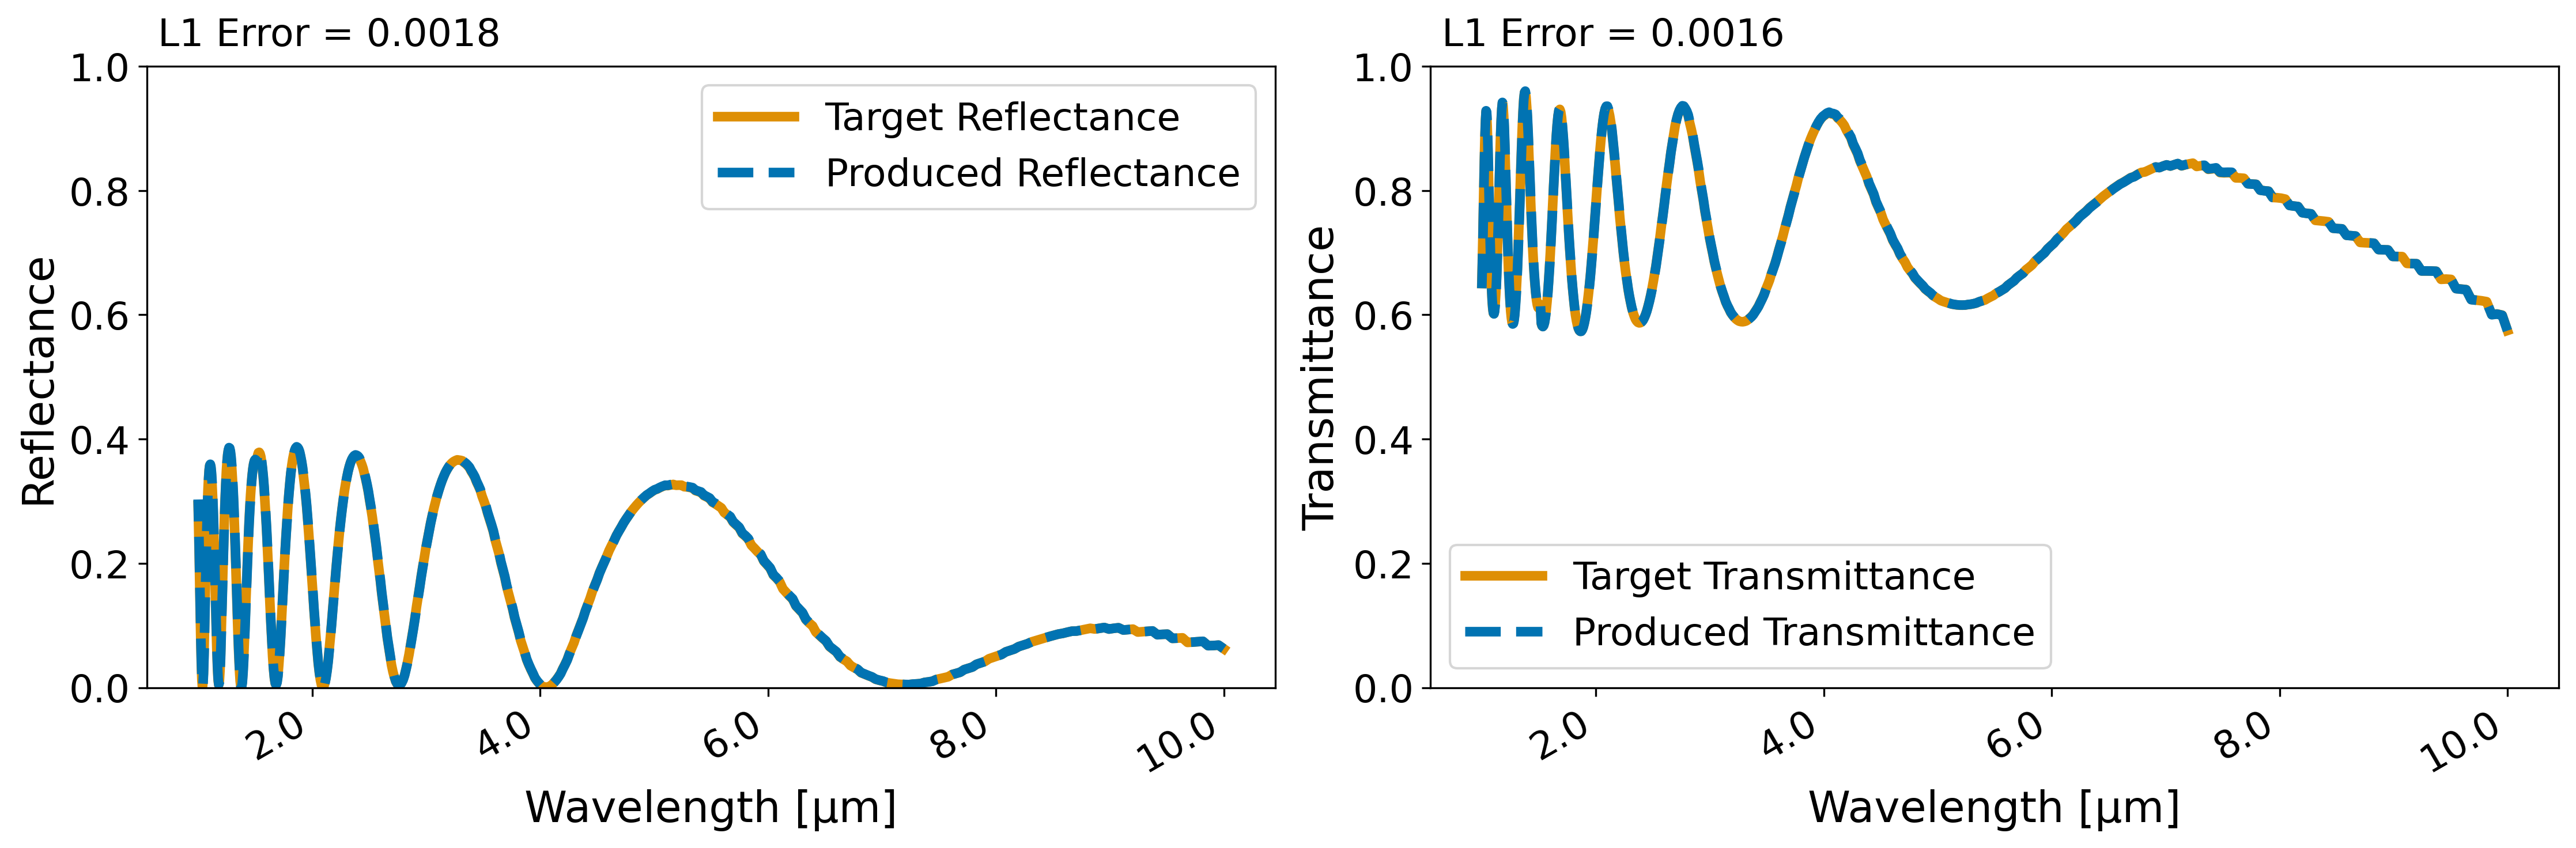

In [16]:
cfg.target_reflectance_spectrum = Rs
cfg.target_transmittance_spectrum = Ts
nidn.plot_spectra(cfg,prod_R_spectrum=R_nidn,prod_T_spectrum=T_nidn,markers=False,
                  save_path="../../results/",filename="trcwa_vs_grcwa_grid")

In [17]:
R_errs = np.abs(np.array(R_nidn) - np.array(Rs))
T_errs = np.abs(np.array(T_nidn) - np.array(Ts))
print("R_errs",R_errs.mean())
print("T_errs",T_errs.mean())
errs = np.concatenate([R_errs,T_errs])
print("Overall",errs.mean())

R_errs 0.0017755116751273646
T_errs 0.0016405935015893314
Overall 0.001708052588358348
